# Experiments with real data (kc houses)

https://www.mdpi.com/2227-7390/9/18/2247

## Requirements

In [5]:
import os, sys, pickle
import polars as pl
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
from BigEDA.descriptive import outliers_table, summary
from BigEDA.plots import boxplot_matrix, histogram_matrix, barplot_matrix, ecdfplot_matrix
from datetime import datetime
from zoneinfo import ZoneInfo  
from tqdm import tqdm
import random
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import pandas as pd
from PyDistances.mixed import FastGGowerDistMatrix
from sklearn.manifold import MDS
from FastKmedoids.plots import clustering_MDS_plot_multiple_methods
from FastKmedoids.models import FastKmedoidsGGower, FoldFastKmedoidsGGower
from sklearn_extra.cluster import KMedoids, CLARA
from sklearn.cluster import (KMeans, AgglomerativeClustering,
                             SpectralClustering, SpectralBiclustering, SpectralCoclustering, Birch, 
                             BisectingKMeans, MiniBatchKMeans)
from sklearn.mixture import GaussianMixture
from clustpy.partition import SubKmeans, LDAKmeans, DipInit
from clustpy.hierarchical import Diana

sns.set_style('whitegrid')

current_path = os.getcwd()
data_path = os.path.join(current_path, '..', '..', 'data')
data_filename = 'kc_houses_processed.pkl'
data_file_path = os.path.join(data_path, data_filename)

src_path = os.path.join(current_path, '..', '..', 'src')
config_path = os.path.join(current_path, '..',  '..', 'config')

sys.path.append(src_path)
sys.path.append(config_path)

from experiments_utils import (make_experiment_1, 
                               make_experiment_3, 
                               make_experiment_4,
                               get_pivoted_results, get_avg_results,
                               get_pivoted_results_two_iterables,
                               get_avg_results_two_iterables,
                               avg_results_to_dfs,
                               get_GGower_distances_names,
                               split_list_in_chunks)

from config_experiment_1_kc_houses import get_config as get_config_exp_1_kc_houses
from config_experiment_3_kc_houses import get_config as get_config_exp_3_kc_houses
from config_experiment_4_kc_houses import get_config as get_config_exp_4_kc_houses

## Data exploration


### Conceptual description


| Variable | Descripción | Rol | Tipo de Dato | Valores / Unidades |
| :--- | :--- | :--- | :--- | :--- |
| **price** | Precio de venta de cada casa. | **Target** | Numérica (continua) | Valor monetario (dólares). |
| **id** | Identificador único de cada casa. | ID | Numérica (entera) | Identificador. |
| **date** | Fecha de la venta de la casa. | Feature | Fecha | Fecha de venta. |
| **bedrooms** | Número de dormitorios. | Feature | Numérica (entera) | Conteo (ej. 3, 4, 5). |
| **bathrooms** | Número de baños. | Feature | Numérica (continua) | Conteo (ej. 2.5, 3.0). |
| **sqft_living** | Pies cuadrados (sqft) del espacio habitable interior. | Feature | Numérica (entera) | Pies cuadrados. |
| **sqft_lot** | Pies cuadrados (sqft) del espacio del terreno. | Feature | Numérica (entera) | Pies cuadrados. |
| **floors** | Número de pisos. | Feature | Numérica (continua) | Conteo (ej. 1.0, 2.0). |
| **waterfront** | Indicador de si la casa da al frente de agua. | Feature | **Binaria** | 1: Sí (frente al agua), 0: No. |
| **view** | Calificación de la vista desde la propiedad. | Feature | Categórica (ordinal) | Índice de 0 a 4. |
| **condition** | Calificación del estado/condición de la casa. | Feature | Categórica (ordinal) | Índice de 1 a 5. |
| **grade** | Calificación de la calidad de construcción y diseño. | Feature | Categórica (ordinal) | Índice de 1 a 13. |
| **sqft_above** | Pies cuadrados (sqft) del espacio habitable sobre el nivel del suelo. | Feature | Numérica (entera) | Pies cuadrados. |
| **sqft_basement** | Pies cuadrados (sqft) del espacio habitable bajo el nivel del suelo (sótano). | Feature | Numérica (entera) | Pies cuadrados. |
| **yr_built** | Año en que se construyó la casa inicialmente. | Feature | Numérica (entera) | Año (ej. 1955, 2004). |
| **yr_renovated** | Año de la última renovación de la casa. | Feature | Numérica (entera) | Año (0 si no fue renovada). |
| **zipcode** | Código postal del área donde se ubica la casa. | Feature | Categórica (nominal) | Código postal (entero). |
| **lat** | Latitud. | Feature | Numérica (continua) | Coordenadas geográficas. |
| **long** | Longitud. | Feature | Numérica (continua) | Coordenadas geográficas. |
| **sqft_living15** | Pies cuadrados (sqft) del espacio habitable interior de los 15 vecinos más cercanos. | Feature | Numérica (entera) | Pies cuadrados. |
| **sqft_lot15** | Pies cuadrados (sqft) del terreno de los 15 vecinos más cercanos. | Feature | Numérica (entera) | Pies cuadrados. |


### Data reading

In [9]:
with open(data_file_path, "rb") as f:
    loaded_data = pickle.load(f)

df, X, y, p1, p2, p3, n_clusters, encoding, quant_predictors, binary_predictors, multiclass_predictors = loaded_data.values()

n_clusters = len(y.unique())

### Data view

In [20]:
X.head()


bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,waterfront,view,condition,grade
i64,f64,i64,i64,f64,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64
3,1.0,1180,5650,1.0,1180,0,1955,47.5112,-122.257,1340,5650,0,0,2,4
3,2.25,2570,7242,2.0,2170,400,1951,47.721,-122.319,1690,7639,0,0,2,4
2,1.0,770,10000,1.0,770,0,1933,47.7379,-122.233,2720,8062,0,0,2,3
4,3.0,1960,5000,1.0,1050,910,1965,47.5208,-122.393,1360,5000,0,0,4,4
3,2.0,1680,8080,1.0,1680,0,1987,47.6168,-122.045,1800,7503,0,0,2,5


In [21]:

X.shape


(21597, 16)

In [22]:

y.head(5)


price
i64
0
1
0
1
1


In [23]:

y.shape


(21597,)

In [24]:

n_clusters


3

In [25]:

print(p1, p2, p3)


3 12 1


In [26]:

encoding


{'price': {'low': 0, 'medium': 1, 'high': 2},
 'waterfront': {0: 0, 1: 1},
 'view': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
 'condition': {1: 0, 2: 1, 3: 2, 4: 3, 5: 4},
 'grade': {3: 0,
  4: 1,
  5: 2,
  6: 3,
  7: 4,
  8: 5,
  9: 6,
  10: 7,
  11: 8,
  12: 9,
  13: 10}}

In [27]:

quant_predictors


['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [28]:

binary_predictors


['waterfront']

In [29]:

multiclass_predictors

['view', 'condition', 'grade']

### Data description

In [30]:
quant_summary, cat_summary = summary(df=X, quant_col_names = quant_predictors, cat_col_names = binary_predictors + multiclass_predictors)

In [31]:
quant_summary

,n_unique,perc_nan,mean,std,min,Q10,Q25,median,Q75,Q90,max,kurtosis,skew,prop_outliers
bedrooms,12,0.0,3.3732,0.926299,1.0,2.0,3.0,3.0,4.0,4.0,33.0,52.810023,2.023501,0.02454
bathrooms,29,0.0,2.115826,0.768984,0.5,1.0,1.75,2.25,2.5,3.0,8.0,4.278741,0.519673,0.025976
sqft_living,1034,0.0,2080.32185,918.106125,370.0,1090.0,1430.0,1910.0,2550.0,3250.0,13540.0,8.250608,1.473113,0.026439
sqft_lot,9776,0.0,15099.40876,41412.636876,520.0,3323.0,5040.0,7618.0,10685.0,21370.0,1651359.0,288.429442,13.071696,0.112006
floors,6,0.0,1.494096,0.539683,1.0,1.0,1.0,1.5,2.0,2.0,3.5,2.50877,0.614454,0.0
sqft_above,942,0.0,1788.596842,827.759761,370.0,970.0,1190.0,1560.0,2210.0,2950.0,9410.0,6.404454,1.447334,0.028245
sqft_basement,306,0.0,291.725008,442.6678,0.0,0.0,0.0,0.0,560.0,970.0,4820.0,5.710893,1.57678,0.022966
yr_built,116,0.0,1970.999676,29.375234,1900.0,1926.0,1951.0,1975.0,1997.0,2007.0,2015.0,2.34218,-0.469417,0.0
lat,5033,0.0,47.560093,0.138552,47.1559,47.3503,47.4711,47.5718,47.678,47.7279,47.7776,2.324088,-0.485488,0.000093
long,751,0.0,-122.213982,0.140724,-122.519,-122.372,-122.328,-122.231,-122.125,-122.022,-121.315,4.051599,0.884827,0.011807


In [32]:
cat_summary

,n_unique,perc_nan,mode
waterfront,2,0.0,0
view,5,0.0,0
condition,5,0.0,2
grade,11,0.0,4


In [33]:
y.describe()

statistic,value
str,f64
"""count""",21597.0
"""null_count""",0.0
"""mean""",1.000787
"""std""",0.707336
"""min""",0.0
"""25%""",1.0
"""50%""",1.0
"""75%""",2.0
"""max""",2.0


In [35]:
# Proportion of individuals per cluster/group
unique_values, counts = np.unique(y, return_counts=True)
prop_clusters = np.round(counts/len(y), 2)
prop_clusters = {k: v for k, v in zip(unique_values, prop_clusters)}
print(f'prop_clusters: {prop_clusters}')

prop_clusters: {0: 0.25, 1: 0.5, 2: 0.25}


In [35]:
outliers_df = outliers_table(X, auto=False, col_names=quant_predictors, h=1.5)
outliers_df

quant_variables,lower_bound,upper_bound,n_outliers,n_not_outliers,prop_outliers,prop_not_outliers
str,f64,f64,i64,i64,f64,f64
"""bedrooms""",1.5,5.5,530,21067,0.02454,0.97546
"""bathrooms""",0.625,3.625,561,21036,0.025976,0.974024
"""sqft_living""",-250.0,4230.0,571,21026,0.026439,0.973561
"""sqft_lot""",-3427.5,19152.5,2419,19178,0.112006,0.887994
"""floors""",-0.5,3.5,0,21597,0.0,1.0
…,…,…,…,…,…,…
"""yr_built""",1882.0,2066.0,0,21597,0.0,1.0
"""lat""",47.16075,47.98835,2,21595,0.000093,0.999907
"""long""",-122.6325,-121.8205,255,21342,0.011807,0.988193


In [36]:
outliers_df['prop_outliers'].mean()

0.03154373292586934

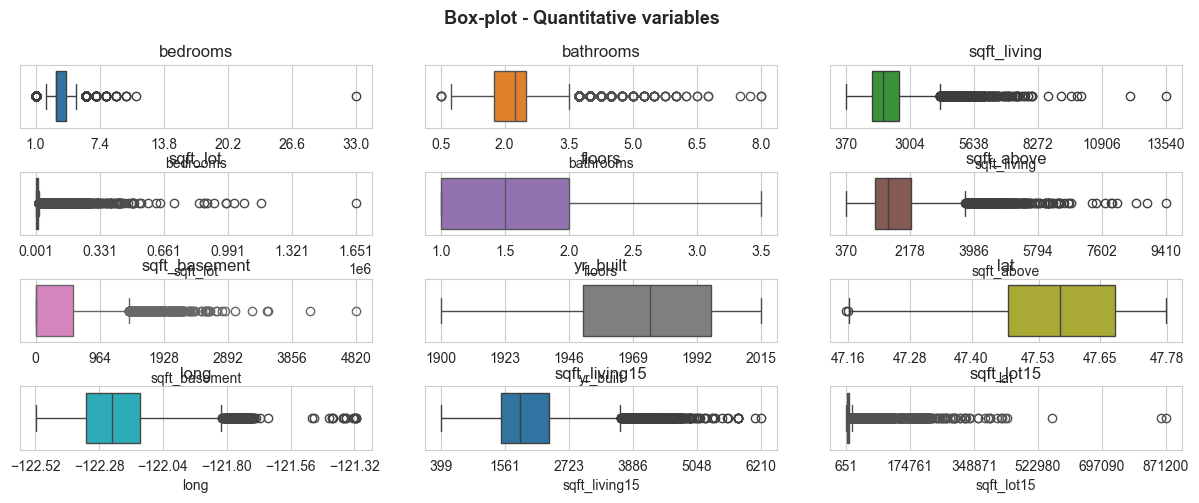

In [37]:
# Boxplot after outliers contamination
boxplot_matrix(X, 
               n_cols=3, 
               title='Box-plot - Quantitative variables', 
               figsize=(15,5), 
               quant_col_names=quant_predictors, 
               n_xticks=6, 
               title_fontsize=13, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.99,
               style='whitegrid', 
               hspace=0.7, 
               wspace=0.15, 
               title_weight='bold',
               subtitles_fontsize=12, 
               xlabel_size=10)

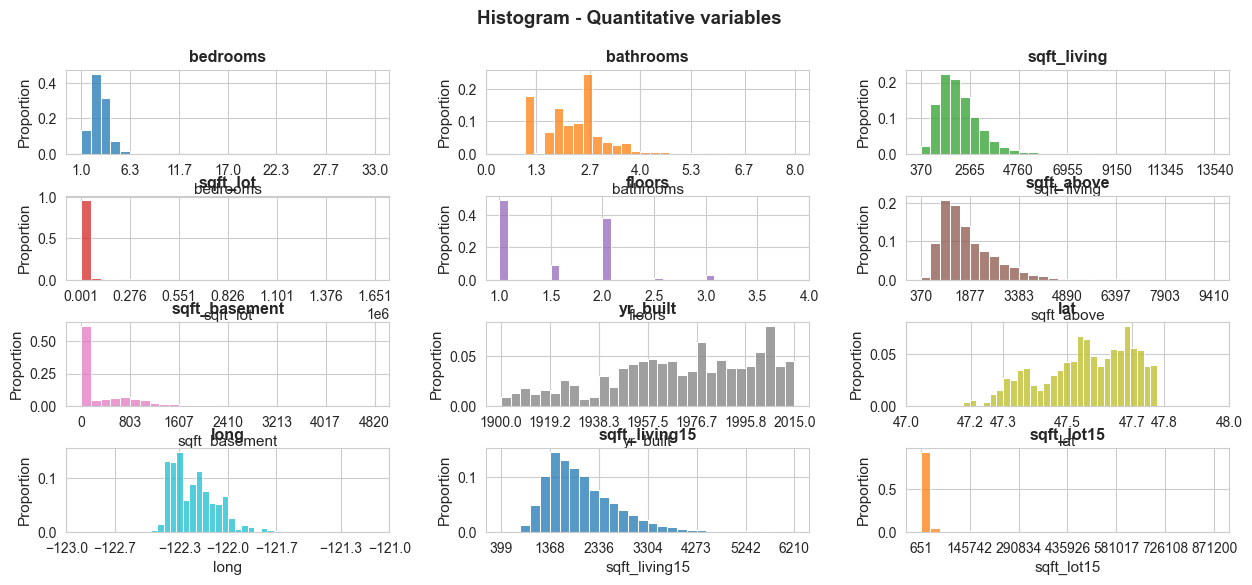

In [38]:
# Histogram
histogram_matrix(df=X, bins=30, n_cols=3, title='Histogram - Quantitative variables', 
                 figsize=(15,6), quant_col_names=quant_predictors, 
                 n_xticks=7, title_fontsize=13.5, 
                 subtitles_fontsize=11.5, save=False, file_name='', x_rotation=0, title_height=0.98,
                 style='whitegrid', hspace=0.5, wspace=0.3, n_round_xticks=1)

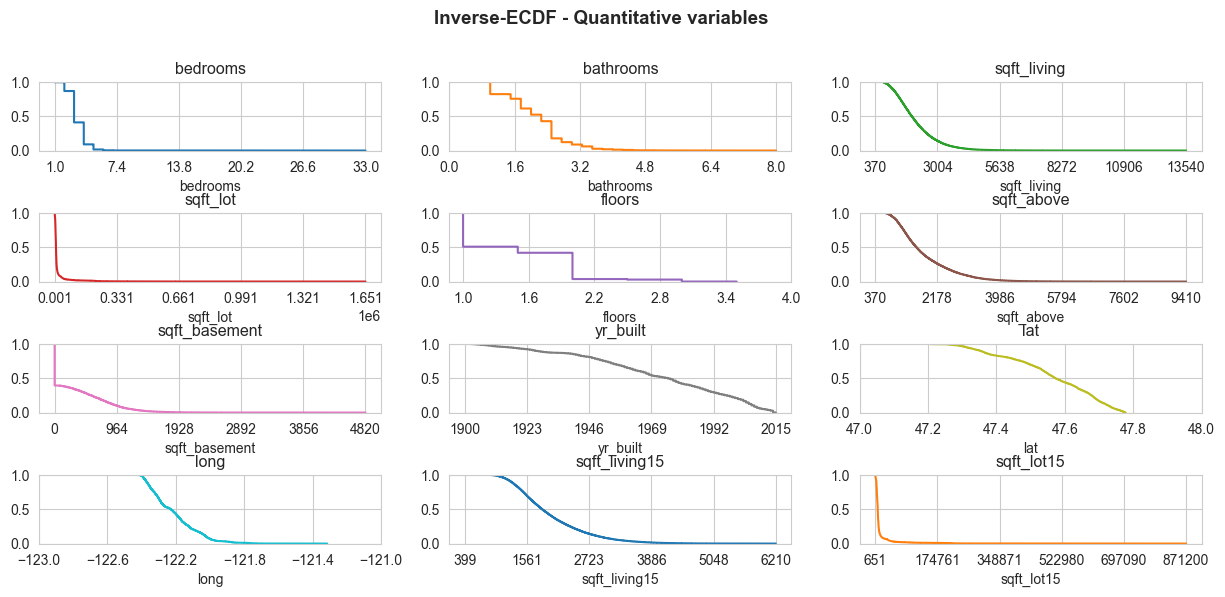

In [39]:
ecdfplot_matrix(df=X, 
                n_cols=3, 
                title='Inverse-ECDF - Quantitative variables', 
                complementary=True, 
                figsize=(15,6), 
                auto_col=False, 
                quant_col_names = quant_predictors, 
                title_weight='bold',
                n_xticks=6, 
                title_fontsize=13.5, 
                subtitles_fontsize=11.5, 
                save=False, 
                file_name=None, 
                random=False, 
                n=None, 
                fraction=None, 
                seed=123, 
                x_rotation=0, 
                title_height=1,
                style='whitegrid', 
                hspace=0.9, 
                wspace=0.2,
                n_round_xticks=2, 
                xlabel_size=10) 

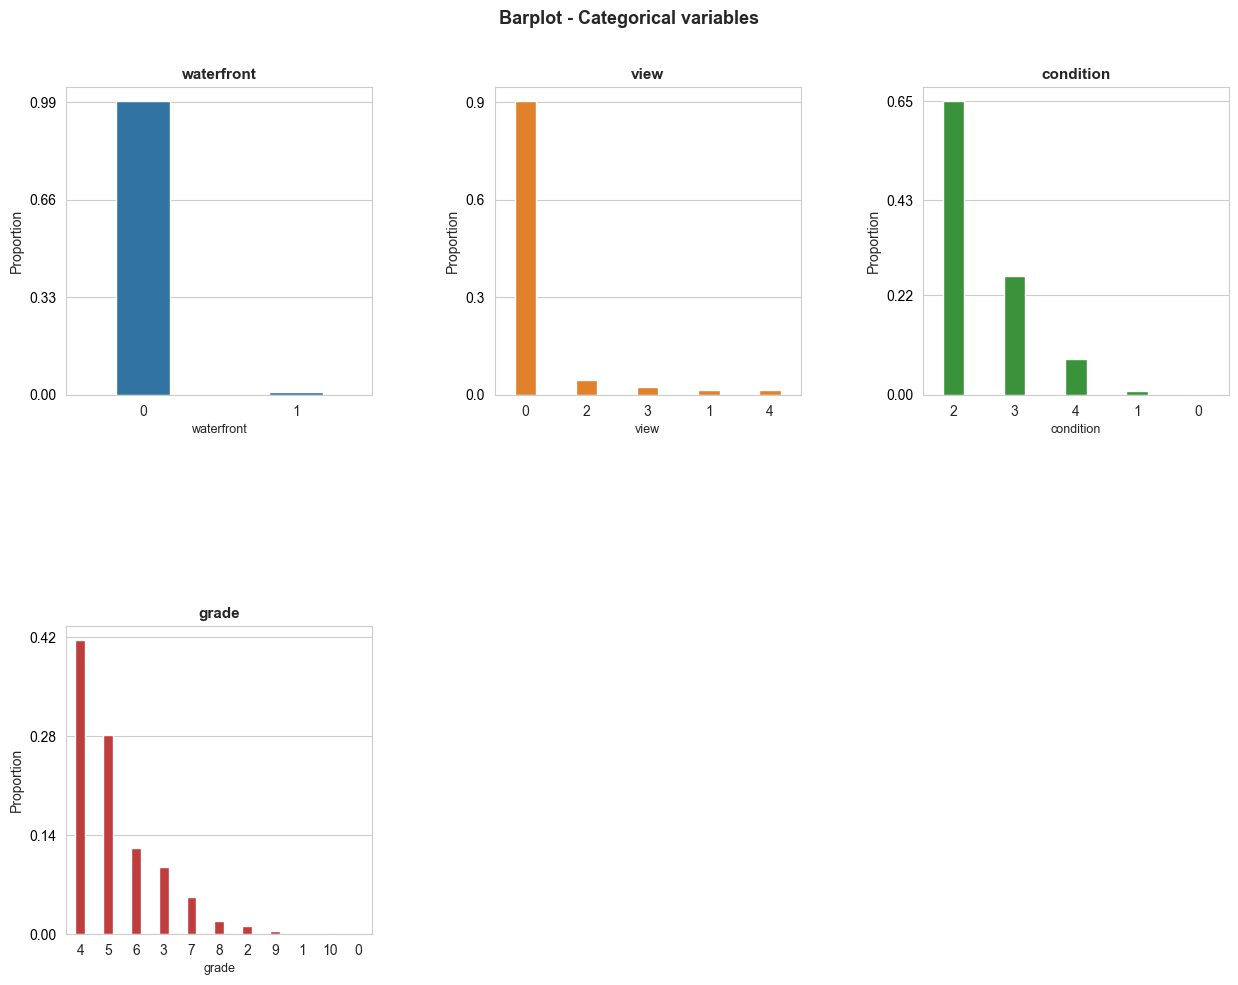

In [40]:
# Barplot
barplot_matrix(df=X, 
               n_cols=3, 
               title='Barplot - Categorical variables', 
               figsize=(15,11), 
               cat_col_names = binary_predictors + multiclass_predictors, 
               title_fontsize=13, 
               subtitles_fontsize=11, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.95,
               style='whitegrid', 
               hspace=0.75, 
               wspace=0.4, 
               title_weight='bold', 
               bar_width=0.35,
               ylabel_size=10, 
               xlabel_size=9, 
               xticks_size=10)

In [41]:
# Correlation Matrix
X[quant_predictors].to_pandas().corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15
bedrooms,1.000000,0.514508,0.578212,0.032471,0.177944,0.479386,0.302808,0.155670,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.514508,1.000000,0.755758,0.088373,0.502582,0.686668,0.283440,0.507173,0.024280,0.224903,0.569884,0.088303
sqft_living,0.578212,0.755758,1.000000,0.173453,0.353953,0.876448,0.435130,0.318152,0.052155,0.241214,0.756402,0.184342
sqft_lot,0.032471,0.088373,0.173453,1.000000,-0.004814,0.184139,0.015418,0.052946,-0.085514,0.230227,0.144763,0.718204
floors,0.177944,0.502582,0.353953,-0.004814,1.000000,0.523989,-0.245715,0.489193,0.049239,0.125943,0.280102,-0.010722
sqft_above,0.479386,0.686668,0.876448,0.184139,0.523989,1.000000,-0.052156,0.424037,-0.001199,0.344842,0.731767,0.195077
sqft_basement,0.302808,0.283440,0.435130,0.015418,-0.245715,-0.052156,1.000000,-0.133064,0.110414,-0.144546,0.200443,0.017550
yr_built,0.155670,0.507173,0.318152,0.052946,0.489193,0.424037,-0.133064,1.000000,-0.148370,0.409993,0.326377,0.070777
lat,-0.009951,0.024280,0.052155,-0.085514,0.049239,-0.001199,0.110414,-0.148370,1.000000,-0.135371,0.048679,-0.086139
long,0.132054,0.224903,0.241214,0.230227,0.125943,0.344842,-0.144546,0.409993,-0.135371,1.000000,0.335626,0.255586


In [42]:
# Correlation Analysis
corr_matrix = X[quant_predictors].corr().to_numpy()
n_corr = len(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
n_corr_below_30 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) < 0.30)
n_corr_above_60 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) > 0.60)
n_corr_between = np.sum((np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) >= 0.30) & (np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) <= 0.60))
                        
print('Proportion of pair-wise correlation > 0.60 (in abs. value): ', np.round(n_corr_above_60 / n_corr, 2))
print('Proportion of pair-wise correlations in [0.30, 0.60]: ', np.round(n_corr_between / n_corr, 2))
print('Proportion of pair-wise correlation < 0.30 (in abs. value): ', np.round(n_corr_below_30 / n_corr, 2))

Proportion of pair-wise correlation > 0.60 (in abs. value):  0.09
Proportion of pair-wise correlations in [0.30, 0.60]:  0.27
Proportion of pair-wise correlation < 0.30 (in abs. value):  0.64


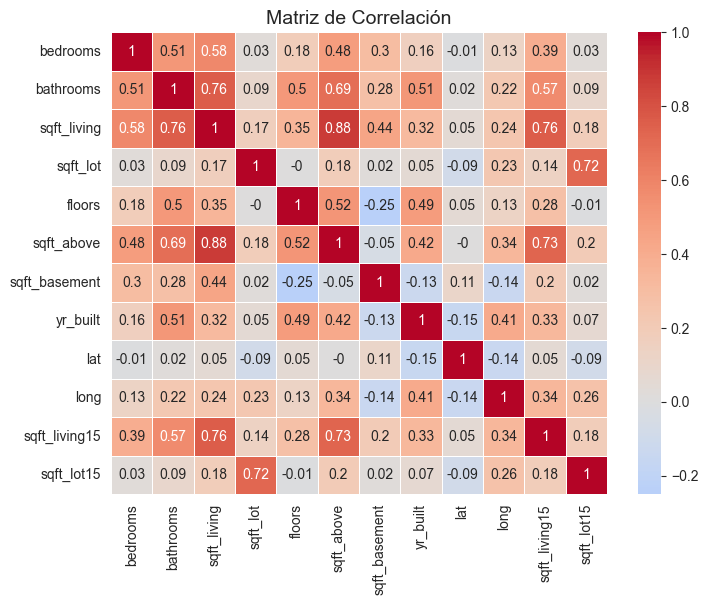

In [43]:
# Suponiendo que ya tienes tu matriz de correlaciones
corr = X[quant_predictors].to_pandas().corr().round(2)

plt.figure(figsize=(8,6))
sns.heatmap(corr, 
            annot=True,        # Muestra los valores dentro de cada celda
            cmap="coolwarm",   # Paleta de colores (azul-rojo)
            center=0,          # Centra el mapa en 0
            linewidths=0.5)    # Líneas entre celdas
plt.title("Matriz de Correlación", fontsize=14)
plt.show()


## Experiment 1


In [29]:
run_experiment_1 = True

In [30]:
if run_experiment_1: 
        
    n_realizations = 100
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 5
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_1', 'kc_houses')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20250930_130045'

    config_exp_1 = get_config_exp_1_kc_houses()
   
    config_exp_1.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

    if not isinstance(y, np.ndarray):
        y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_1

In [ ]:
if run_experiment_1: 

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks', position=0)):
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)
                
            results[random_state] = make_experiment_1(**config_exp_1,
                                                    X=X, 
                                                    y=y,
                                                    random_state=random_state,
                                                    metric=balanced_accuracy_score #accuracy_score
                                                )
            
        # Save results
        results_filename = f'results_exp_1_kc_houses_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 100 realizations: 153  mins

chunks:   0%|          | 0/20 [00:00<?, ?chunks/s]

random_state_chunk: [6863, 35084, 11427, 53377, 34937]
random_state: 6863
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 35084
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 11427
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 53377
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3


chunks:   5%|▌         | 1/20 [15:24<4:52:53, 924.94s/chunks]

len y_pred: 3
random_state_chunk: [14116, 5000, 49692, 70281, 73704]
random_state: 14116
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 5000
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 49692
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 70281
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sam

chunks:  10%|█         | 2/20 [29:44<4:25:56, 886.46s/chunks]

len y_pred: 3
random_state_chunk: [43541, 44669, 6802, 20927, 17702]
random_state: 43541
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 44669
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 6802
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 20927
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sam

chunks:  15%|█▌        | 3/20 [40:41<3:41:31, 781.85s/chunks]

len y_pred: 3
random_state_chunk: [44199, 73526, 43751, 91971, 32134]
random_state: 44199
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 73526
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 43751
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 91971
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_s

chunks:  20%|██        | 4/20 [50:00<3:05:00, 693.80s/chunks]

len y_pred: 3
random_state_chunk: [21466, 218, 57183, 11483, 78328]
random_state: 21466
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 218
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 57183
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 11483
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sampl

chunks:  25%|██▌       | 5/20 [1:01:47<2:54:38, 698.60s/chunks]

len y_pred: 3
random_state_chunk: [49492, 9158, 864, 41347, 95949]
random_state: 49492
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 9158
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 864
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 41347
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_

chunks:  30%|███       | 6/20 [1:16:19<2:56:44, 757.45s/chunks]

len y_pred: 3
random_state_chunk: [58762, 13374, 5752, 12158, 87443]
random_state: 58762
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 13374
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 5752
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 12158
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sam

chunks:  35%|███▌      | 7/20 [1:31:52<2:56:32, 814.80s/chunks]

len y_pred: 3
random_state_chunk: [18635, 16547, 2783, 38247, 56444]
random_state: 18635
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 16547
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 2783
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 38247
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sam

chunks:  40%|████      | 8/20 [1:37:33<2:12:46, 663.87s/chunks]

len y_pred: 3
random_state_chunk: [75157, 62511, 34776, 61511, 4816]
random_state: 75157
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 62511
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 34776
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 61511
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sa

chunks:  45%|████▌     | 9/20 [1:41:48<1:38:19, 536.36s/chunks]

len y_pred: 3
random_state_chunk: [39989, 45018, 68376, 63302, 27113]
random_state: 39989
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 45018
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 68376
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 63302
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_s

chunks:  50%|█████     | 10/20 [1:46:29<1:16:13, 457.38s/chunks]

len y_pred: 3
random_state_chunk: [79810, 83723, 69084, 74031, 41322]
random_state: 79810
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 83723
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 69084
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 74031
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_s

chunks:  55%|█████▌    | 11/20 [1:51:07<1:00:21, 402.35s/chunks]

len y_pred: 3
random_state_chunk: [1644, 52197, 84692, 67207, 56935]
random_state: 1644
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 52197
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 84692
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 67207
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sam

chunks:  60%|██████    | 12/20 [1:55:52<48:54, 366.85s/chunks]  

len y_pred: 3
random_state_chunk: [89762, 70584, 83670, 87380, 78185]
random_state: 89762
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 70584
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 83670
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 87380
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_s

chunks:  65%|██████▌   | 13/20 [2:00:40<40:00, 342.93s/chunks]

len y_pred: 3
random_state_chunk: [63718, 68237, 87617, 54984, 49089]
random_state: 63718
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 68237
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 87617
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 54984
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_s

chunks:  70%|███████   | 14/20 [2:05:22<32:26, 324.48s/chunks]

len y_pred: 3
random_state_chunk: [66855, 4173, 98850, 84600, 23784]
random_state: 66855
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 4173
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 98850
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 84600
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sam

chunks:  75%|███████▌  | 15/20 [2:10:09<26:05, 313.16s/chunks]

len y_pred: 3
random_state_chunk: [95135, 10827, 63819, 86255, 34326]
random_state: 95135
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 10827
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 63819
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 86255
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_s

chunks:  80%|████████  | 16/20 [2:14:56<20:21, 305.32s/chunks]

len y_pred: 3
random_state_chunk: [22298, 43896, 44160, 72640, 51274]
random_state: 22298
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 43896
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 44160
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 72640
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_s

chunks:  85%|████████▌ | 17/20 [2:19:35<14:52, 297.40s/chunks]

len y_pred: 3
random_state_chunk: [9606, 94779, 59869, 50810, 75126]
random_state: 9606
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 94779
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 59869
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 50810
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sam

chunks:  90%|█████████ | 18/20 [2:24:15<09:44, 292.29s/chunks]

len y_pred: 3
random_state_chunk: [44054, 2137, 24780, 76834, 11554]
random_state: 44054
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 2137
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 24780
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 76834
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sam

chunks:  95%|█████████▌| 19/20 [2:28:55<04:48, 288.46s/chunks]

len y_pred: 3
random_state_chunk: [82354, 47646, 1681, 46126, 30032]
random_state: 82354
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 47646
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 1681
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sample_size: 0.3
len y_pred: 3
random_state: 46126
frac_sample_size: 0.005
len y_pred: 3
frac_sample_size: 0.01
len y_pred: 3
frac_sample_size: 0.05
len y_pred: 3
frac_sample_size: 0.1
len y_pred: 3
frac_sample_size: 0.2
len y_pred: 3
frac_sam

chunks: 100%|██████████| 20/20 [2:33:31<00:00, 460.59s/chunks]

len y_pred: 3


In [32]:
if run_experiment_1: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_1', 'kc_houses')
    file_id = '20250930_130045'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_1_kc_houses_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_1_kc_houses_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [2]:
# Open merged/joined results 

file_id = '20250930_130045'
results_filename = f'results_exp_1_kc_houses_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_1', 'kc_houses')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [3]:
experiment_1_config = get_config_exp_1_kc_houses()

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

In [4]:
frac_sample_sizes_list = np.array(list(avg_results['adj_accuracy'].keys()))
adj_accuracy_list = list(avg_results['adj_accuracy'].values())
ari_list = list(avg_results['ARI'].values())
time_list = list(avg_results['time'].values())
best_frac_sample_size = frac_sample_sizes_list[np.argmax(adj_accuracy_list)]

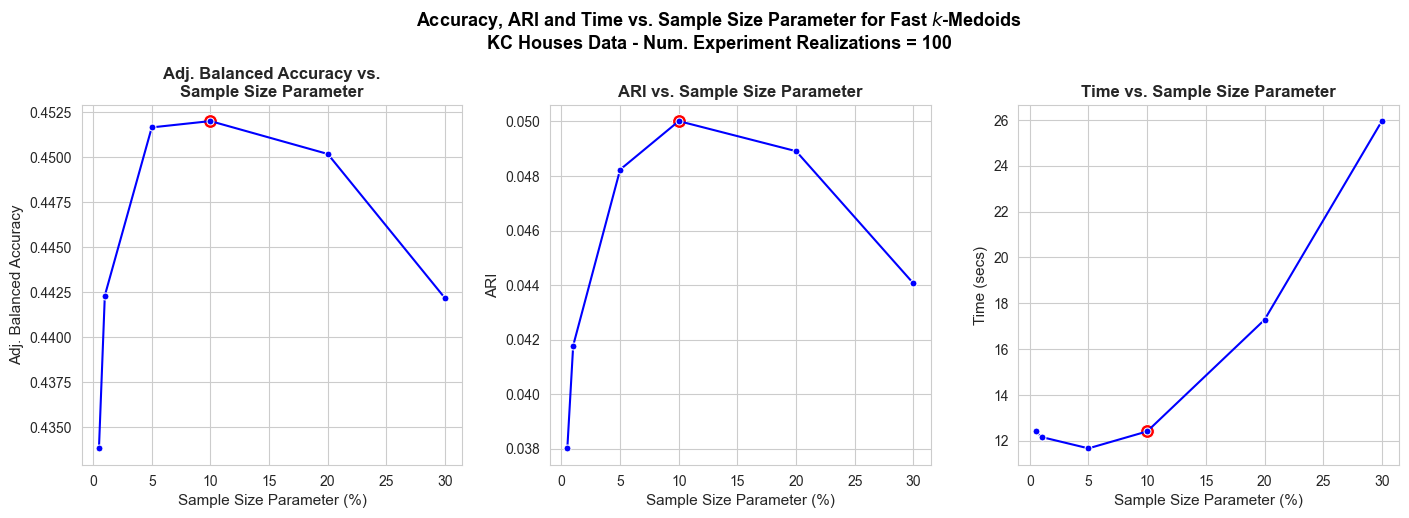

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(17,5))
axes = axes.flatten()  

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['adj_accuracy'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[0])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=adj_accuracy_list, 
    color='blue', marker='o',  markersize=5, ax=axes[0]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['ARI'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[1])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=ari_list, 
    color='blue', marker='o',  markersize=5, ax=axes[1]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['time'][best_frac_sample_size]], color='red', marker='o', markersize=10, ax=axes[2])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=time_list, 
    color='blue', marker='o', markersize=5, ax=axes[2]
)

axes[0].set_title('Adj. Balanced Accuracy vs.\nSample Size Parameter', size=12, weight='bold')
axes[0].set_ylabel('Adj. Balanced Accuracy', size=11)
#axes[0].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[1].set_title('ARI vs. Sample Size Parameter', size=12, weight='bold')
axes[1].set_ylabel('ARI', size=11)
#axes[1].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[2].set_title('Time vs. Sample Size Parameter', size=12, weight='bold')
axes[2].set_ylabel('Time (secs)', size=11)
#axes[2].set_yticks(np.round(np.linspace(np.min(times_values), np.max(times_values), 7),1))

for i in range(len(axes)):
    #axes[i].set_xticks(np.round(np.linspace(np.min(data_perc_sizes), np.max(data_perc_sizes), 7),1))
    axes[i].set_xlabel('Sample Size Parameter (%)', size=11)

#plt.tight_layout()
plt.subplots_adjust(top=0.83)
plt.suptitle('Accuracy, ARI and Time vs. Sample Size Parameter for Fast $k$-Medoids\nKC Houses Data - Num. Experiment Realizations = 100', fontsize=13, y=1.02, weight='bold', color='black', alpha=1)
plt.subplots_adjust(hspace=0.5, wspace=0.23) 

plot_filename = f'plot_results_exp_1_kc_houses_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
if not os.path.exists(plot_save_path):
    fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [8]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'frac_sample_size'
avg_results_df

,time,adj_accuracy,ARI
frac_sample_size,,,
0.005,12.438493,0.433807,0.038011
0.010,12.158274,0.442297,0.041781
0.050,11.663637,0.451639,0.048234
0.100,12.404026,0.451990,0.050013
0.200,17.273978,0.450162,0.048909
0.300,25.947253,0.442143,0.044059


In [9]:
print(best_frac_sample_size)

0.1



## Experiment 3


In [2]:
run_experiment_3 = True

In [ ]:
if run_experiment_3: 

    n_realizations = 100
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_3', 'kc_houses')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20250930_155234'

    config_exp_3 = get_config_exp_3_kc_houses()
    
    config_exp_3.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

    if not isinstance(y, np.ndarray):
        y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_1

In [ ]:
if run_experiment_3: 

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)    

            results[random_state] = make_experiment_3(**config_exp_3,
                                                    X=X, 
                                                    y=y,
                                                    random_state=random_state,
                                                    metric=balanced_accuracy_score # accuracy_score
                                                )

        # Save results
        results_filename = f'results_exp_3_kc_houses_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 10 realizations: 300 mins

chunks:   0%|          | 0/9 [00:00<?, ?chunks/s]

random_state_chunk: [95135, 10827, 63819]
random_state: 95135
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:43<00:00,  4.32s/it]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [01:02<00:00,  4.14s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:30<00:00,  2.04s/it]


n_splits: 20
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:00<00:00,  3.05s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:30<00:00,  1.54s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


random_state: 10827
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:12<00:00,  2.51s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.38s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:19<00:00,  1.33s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:19<00:00,  1.33s/it]


n_splits: 20
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 20/20 [01:08<00:00,  3.45s/it]


random_state: 63819
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:35<00:00,  7.03s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:26<00:00,  5.31s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:19<00:00,  1.33s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:19<00:00,  1.27s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:19<00:00,  1.31s/it]


n_splits: 20
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


frac_sample_size: 0.3


chunks:  11%|█         | 1/9 [15:25<2:03:20, 925.10s/chunks]

random_state_chunk: [86255, 34326, 22298]
random_state: 86255
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:43<00:00,  4.36s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:55<00:00,  5.52s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:25<00:00,  2.55s/it]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:59<00:00,  3.99s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:42<00:00,  2.83s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:51<00:00,  3.46s/it]


n_splits: 20
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [00:40<00:00,  2.03s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [01:03<00:00,  3.15s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 20/20 [00:43<00:00,  2.19s/it]


random_state: 34326
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:28<00:00,  2.81s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [01:11<00:00,  7.17s/it]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:49<00:00,  3.27s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:29<00:00,  1.93s/it]


n_splits: 20
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:16<00:00,  3.81s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


random_state: 22298
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


n_splits: 20
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [00:30<00:00,  1.55s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


frac_sample_size: 0.3


chunks:  22%|██▏       | 2/9 [34:43<2:03:56, 1062.39s/chunks]

random_state_chunk: [43896, 44160, 72640]
random_state: 43896
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:12<00:00,  2.52s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.35s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:19<00:00,  1.33s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:19<00:00,  1.32s/it]


n_splits: 20
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


random_state: 44160
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:20<00:00,  2.06s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:42<00:00,  2.84s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:29<00:00,  1.94s/it]


n_splits: 20
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [00:34<00:00,  1.72s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.65s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 20/20 [00:28<00:00,  1.45s/it]


random_state: 72640
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.98s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.01s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [01:20<00:00,  5.35s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:23<00:00,  1.57s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:23<00:00,  1.60s/it]


n_splits: 20
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [00:35<00:00,  1.75s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:44<00:00,  2.24s/it]


frac_sample_size: 0.3


chunks:  33%|███▎      | 3/9 [50:14<1:40:14, 1002.43s/chunks]

random_state_chunk: [51274, 9606, 94779]
random_state: 51274
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:35<00:00,  7.17s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:38<00:00,  7.79s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:39<00:00,  7.85s/it]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:54<00:00,  5.47s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:53<00:00,  5.33s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:53<00:00,  5.34s/it]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [01:14<00:00,  4.95s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:50<00:00,  3.38s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:47<00:00,  3.19s/it]


n_splits: 20
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:15<00:00,  3.77s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [01:23<00:00,  4.19s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 20/20 [01:13<00:00,  3.67s/it]


random_state: 9606
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:40<00:00,  8.08s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:42<00:00,  8.54s/it]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:27<00:00,  2.78s/it]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:31<00:00,  2.13s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.53s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.65s/it]


n_splits: 20
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


random_state: 94779
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.40s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.40s/it]


n_splits: 20
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [00:26<00:00,  1.35s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:26<00:00,  1.34s/it]


frac_sample_size: 0.3


chunks:  44%|████▍     | 4/9 [1:12:01<1:33:32, 1122.41s/chunks]

random_state_chunk: [59869, 50810, 75126]
random_state: 59869
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:53<00:00,  5.39s/it]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [01:06<00:00,  4.40s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:55<00:00,  3.70s/it]


n_splits: 20
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [01:43<00:00,  5.15s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 20/20 [01:52<00:00,  5.63s/it]


random_state: 50810
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:29<00:00,  5.88s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:23<00:00,  1.55s/it]


n_splits: 20
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [00:36<00:00,  1.84s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:36<00:00,  1.85s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 20/20 [00:37<00:00,  1.87s/it]


random_state: 75126
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:23<00:00,  4.63s/it]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:30<00:00,  2.02s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:29<00:00,  1.99s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:29<00:00,  1.96s/it]


n_splits: 20
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [00:33<00:00,  1.67s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.65s/it]


frac_sample_size: 0.3


chunks:  56%|█████▌    | 5/9 [1:30:48<1:14:56, 1124.18s/chunks]

random_state_chunk: [44054, 2137, 24780]
random_state: 44054
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:17<00:00,  3.42s/it]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:21<00:00,  2.19s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:26<00:00,  1.76s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:23<00:00,  1.54s/it]


n_splits: 20
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 20/20 [00:37<00:00,  1.86s/it]


random_state: 2137
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:25<00:00,  5.08s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:51<00:00, 10.27s/it]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.71s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:59<00:00,  5.93s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:58<00:00,  5.86s/it]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [01:07<00:00,  4.49s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


n_splits: 20
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [00:26<00:00,  1.30s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:25<00:00,  1.30s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 20/20 [00:30<00:00,  1.54s/it]


random_state: 24780
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:28<00:00,  5.67s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:17<00:00,  3.44s/it]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:23<00:00,  2.30s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.68s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:45<00:00,  3.04s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [01:14<00:00,  4.95s/it]


n_splits: 20
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:24<00:00,  4.23s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


frac_sample_size: 0.3


chunks:  67%|██████▋   | 6/9 [1:51:39<58:22, 1167.39s/chunks]  

random_state_chunk: [76834, 11554, 82354]
random_state: 76834
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:12<00:00,  2.51s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:23<00:00,  4.64s/it]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:19<00:00,  1.96s/it]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.38s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.37s/it]


n_splits: 20
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [00:25<00:00,  1.30s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


random_state: 11554
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:53<00:00,  5.34s/it]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:43<00:00,  2.91s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.38s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:26<00:00,  1.78s/it]


n_splits: 20
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [00:41<00:00,  2.09s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:26<00:00,  1.34s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


random_state: 82354
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:12<00:00,  2.60s/it]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:56<00:00,  5.67s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]


n_splits: 20
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [00:26<00:00,  1.30s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


frac_sample_size: 0.3


chunks:  78%|███████▊  | 7/9 [2:06:23<35:49, 1074.65s/chunks]

random_state_chunk: [47646, 1681, 46126]
random_state: 47646
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.00s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:53<00:00,  5.35s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:45<00:00,  4.58s/it]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.35s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:22<00:00,  1.51s/it]


n_splits: 20
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


random_state: 1681
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:38<00:00,  7.73s/it]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:56<00:00,  5.67s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:54<00:00,  5.41s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:55<00:00,  5.53s/it]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [01:15<00:00,  5.03s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [01:20<00:00,  5.35s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [01:17<00:00,  5.20s/it]


n_splits: 20
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:01<00:00,  3.07s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 20/20 [00:41<00:00,  2.06s/it]


random_state: 46126
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:45<00:00,  9.04s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:19<00:00,  3.85s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:55<00:00,  5.60s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:58<00:00,  5.90s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:47<00:00,  4.79s/it]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:50<00:00,  3.37s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [01:04<00:00,  4.28s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:20<00:00,  1.37s/it]


n_splits: 20
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:26<00:00,  1.34s/it]


frac_sample_size: 0.3


chunks:  89%|████████▉ | 8/9 [2:30:04<19:44, 1184.94s/chunks]

random_state_chunk: [30032]
random_state: 30032
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:20<00:00,  2.00s/it]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:33<00:00,  2.22s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:24<00:00,  1.63s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 15/15 [00:26<00:00,  1.78s/it]


n_splits: 20
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [00:36<00:00,  1.84s/it]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:32<00:00,  1.65s/it]


frac_sample_size: 0.3


chunks: 100%|██████████| 9/9 [2:34:59<00:00, 1033.33s/chunks]


In [32]:
if run_experiment_3: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    file_id = '20250930_155234'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_3_kc_houses_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_3_kc_houses_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [10]:
# Open merged/joined results 

file_id = '20250930_155234'
results_filename = f'results_exp_3_kc_houses_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_3', 'kc_houses')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [11]:
config_exp_3 = get_config_exp_3_kc_houses()

pivoted_results = get_pivoted_results_two_iterables(results = results, 
                                  iterable1 = config_exp_3['n_splits'], 
                                  iterable2 = config_exp_3['frac_sample_sizes'])

avg_results = get_avg_results_two_iterables(results = results, 
                                  pivoted_results = pivoted_results, 
                                  iterable1 = config_exp_3['n_splits'], 
                                  iterable2 = config_exp_3['frac_sample_sizes'])

dfs = avg_results_to_dfs(avg_results, column_1='n_splits', column_2='frac_sample_sizes')

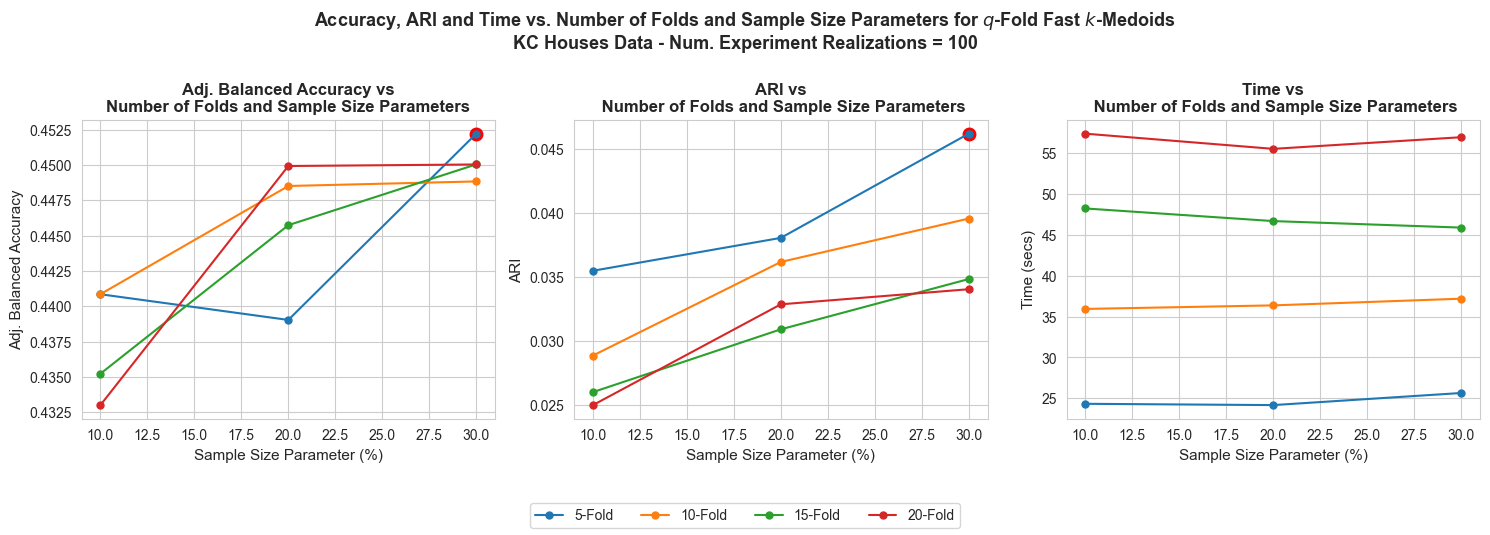

In [14]:
best_combi_acc = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]
best_combi_ari = dfs['ARI'].sort_values(by='ARI', ascending=False).iloc[0]
best_combi_time = dfs['time'].sort_values(by='time', ascending=True).iloc[0]

fig, axes = plt.subplots(1, 3, figsize=(15, 5.5), sharex=True)

# Primer subplot: Accuracy
ax1 = axes[0]
ax1.plot(best_combi_acc['frac_sample_sizes'] * 100, best_combi_acc['adj_accuracy'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['adj_accuracy']['n_splits'].unique()):
    subset = dfs['adj_accuracy'][dfs['adj_accuracy']['n_splits'] == k1]
    ax1.plot(subset['frac_sample_sizes'] * 100, subset['adj_accuracy'], marker='o', markersize=5, label=f"{k1}-Fold")
ax1.set_title("Adj. Balanced Accuracy vs\nNumber of Folds and Sample Size Parameters", fontsize=12, fontweight='bold')
ax1.set_xlabel("Sample Size Parameter (%)", size=11)
ax1.set_ylabel("Adj. Balanced Accuracy", size=11)

# Segundo subplot: Accuracy
ax2 = axes[1]
ax2.plot(best_combi_ari['frac_sample_sizes'] * 100, best_combi_ari['ARI'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['ARI']['n_splits'].unique()):
    subset = dfs['ARI'][dfs['ARI']['n_splits'] == k1]
    ax2.plot(subset['frac_sample_sizes'] * 100, subset['ARI'], marker='o', markersize=5, label=f"{k1}-Fold")
ax2.set_title("ARI vs\n Number of Folds and Sample Size Parameters", fontsize=12, fontweight='bold')
ax2.set_xlabel("Sample Size Parameter (%)", size=11)
ax2.set_ylabel("ARI", size=11)

# Tercer subplot: Time
ax3 = axes[2]
#ax3.plot(best_combi_time['frac_sample_sizes'] * 100, best_combi_time['time'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['time']['n_splits'].unique()):
    subset = dfs['time'][dfs['time']['n_splits'] == k1]
    ax3.plot(subset['frac_sample_sizes'] * 100, subset['time'], marker='o', markersize=5, label=f"{k1}-Fold")
ax3.set_title("Time vs\n Number of Folds and Sample Size Parameters", fontsize=12, fontweight='bold')
ax3.set_xlabel("Sample Size Parameter (%)", size=11)
ax3.set_ylabel("Time (secs)", size=11)

# Título general
fig.suptitle("Accuracy, ARI and Time vs. Number of Folds and Sample Size Parameters for $q$-Fold Fast $k$-Medoids\nKC Houses Data - Num. Experiment Realizations = 100", fontsize=13, fontweight='bold', y=0.95)

# Leyenda común abajo
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize=10)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])

plot_filename = f'plot_results_exp_3_kc_houses_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [15]:
# Results as table
avg_results_df = pd.concat([dfs['adj_accuracy'], dfs['ARI']['ARI'], dfs['time']['time']], axis=1)
avg_results_df

,n_splits,frac_sample_sizes,adj_accuracy,ARI,time
0,5,0.1,0.440850,0.035482,24.338266
1,5,0.2,0.439032,0.038050,24.181151
2,5,0.3,0.452224,0.046188,25.660244
3,10,0.1,0.440856,0.028860,35.937299
4,10,0.2,0.448518,0.036169,36.371071
5,10,0.3,0.448842,0.039558,37.189367
6,15,0.1,0.435222,0.026003,48.219348
7,15,0.2,0.445743,0.030909,46.675576
8,15,0.3,0.450048,0.034834,45.879405
9,20,0.1,0.432999,0.024991,57.361058


In [18]:
n = len(X)
split_ratio = np.round((best_combi_acc['n_splits']/n)*100,3) # best_split = split_ratio * n

print(' split_ratio', split_ratio, '\n', 'best_n_splits', best_combi_acc['n_splits'], '\n', 'best_frac_sample_size', best_combi_acc['frac_sample_sizes'])

 split_ratio 0.023 
 best_n_splits 5.0 
 best_frac_sample_size 0.3



## Experiment 4

In [10]:
config_exp_4 = get_config_exp_4_kc_houses()
    
config_exp_4.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

if not isinstance(y, np.ndarray):
    y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_4

quant_distances_names = ['robust_mahalanobis']
binary_distances_names = ['jaccard', 'sokal']
multiclass_distances_names = ['hamming']
robust_method = ['MAD', 'trimmed', 'winsorized']

GGower_distances_names = get_GGower_distances_names(quant_distances_names, binary_distances_names, multiclass_distances_names, robust_method)

#################################################################################################

# With real data the realizations cannot operate over the randomness of the data
# An alternative approach is to operate over the randomness of the models.

models = {}
n_realizations = 100
experiment_random_state = 123 
random.seed(experiment_random_state)
random_state_list = random.sample(range(n_realizations*1000), n_realizations)

for random_state in random_state_list:


    models[random_state] = {
        
        'KMeans': KMeans(
            n_clusters=config_exp_4['n_clusters'], 
            random_state=random_state, 
            init='k-means++', 
            n_init='auto', 
            max_iter=config_exp_4['max_iter']),

        'CLARA': CLARA(n_clusters=config_exp_4['n_clusters'], 
                       metric='euclidean',
                       random_state=random_state),

        'Diana': Diana(n_clusters=config_exp_4['n_clusters']),

        'LDAKmeans': LDAKmeans(n_clusters=config_exp_4['n_clusters'], random_state=random_state,),

        'SubKmeans': SubKmeans(n_clusters=config_exp_4['n_clusters']),

        'GaussianMixture': GaussianMixture(n_components=config_exp_4['n_clusters'], 
                                           random_state=random_state),

        'AgglomerativeClustering': AgglomerativeClustering(n_clusters=config_exp_4['n_clusters']),

        'SpectralBiclustering': SpectralBiclustering(n_clusters=config_exp_4['n_clusters'], random_state=random_state),

        'SpectralCoclustering': SpectralCoclustering(n_clusters=config_exp_4['n_clusters'], random_state=random_state),

        'Birch': Birch(n_clusters=config_exp_4['n_clusters']),

        'BisectingKMeans': BisectingKMeans(n_clusters=config_exp_4['n_clusters'], 
                                        random_state=random_state, 
                                        max_iter=config_exp_4['max_iter']),

        'MiniBatchKMeans': MiniBatchKMeans(n_clusters=config_exp_4['n_clusters'], 
                                        random_state=random_state, 
                                        max_iter=config_exp_4['max_iter']),

        'KMedoids-euclidean': KMedoids(n_clusters=config_exp_4['n_clusters'], 
                                    metric='euclidean', 
                                    method=config_exp_4['method'], 
                                    init=config_exp_4['init'], 
                                    max_iter=config_exp_4['max_iter'], 
                                    random_state=random_state),
                                    
        #'DipInit': DipInit(n_clusters=config_exp_4['n_clusters'],
        #                    random_state=random_state),

        #'SpectralClustering': SpectralClustering(n_clusters=config_exp_4['n_clusters'],
        #                                         random_state=random_state)
    }

    #################################################################################################

    for d in GGower_distances_names:

        d1, d2, d3 = d.split('-')

        if 'robust' in d1:
            r = d1.split('_')[-1]
            d1 = '_'.join(d1.split('_')[:2])
            label_model_name = f'{d1}_{r}-{d2}-{d3}'
        else:
            r = None
            label_model_name = f'{d1}-{d2}-{d3}'
            
        models[random_state][f'FastKmedoidsGGower-{label_model_name}'] = FastKmedoidsGGower(
                n_clusters=config_exp_4['n_clusters'], 
                method=config_exp_4['method'], 
                init=config_exp_4['init'], 
                max_iter=config_exp_4['max_iter'], 
                random_state=random_state,
                frac_sample_size=config_exp_4['frac_sample_size_fast_kmedoids'], 
                p1=config_exp_4['p1'], 
                p2=config_exp_4['p2'], 
                p3=config_exp_4['p3'], 
                d1=d1, 
                d2=d2, 
                d3=d3, 
                q=1,
                robust_method=r, 
                alpha=config_exp_4['alpha'], 
                epsilon=config_exp_4['epsilon'], 
                n_iters=config_exp_4['n_iters'],
                VG_sample_size=config_exp_4['VG_sample_size'], 
                VG_n_samples=config_exp_4['VG_n_samples']) 

        models[random_state][f'FoldFastKmedoidsGGower-{label_model_name}'] = FoldFastKmedoidsGGower(
                n_clusters=config_exp_4['n_clusters'], 
                method=config_exp_4['method'], 
                init=config_exp_4['init'], 
                max_iter=config_exp_4['max_iter'], 
                random_state=random_state,
                frac_sample_size=config_exp_4['frac_sample_size_fold_fast_kmedoids'], 
                p1=config_exp_4['p1'], 
                p2=config_exp_4['p2'], 
                p3=config_exp_4['p3'], 
                d1=d1, 
                d2=d2, 
                d3=d3, 
                q=1,
                robust_method=r, 
                alpha=config_exp_4['alpha'], 
                epsilon=config_exp_4['epsilon'], 
                n_iters=config_exp_4['n_iters'],
                VG_sample_size=config_exp_4['VG_sample_size'], 
                VG_n_samples=config_exp_4['VG_n_samples'],
                n_splits=config_exp_4['n_splits'], 
                shuffle=config_exp_4['shuffle'], 
                kfold_random_state=random_state) 

In [11]:
run_experiment_4 = True

In [42]:
if run_experiment_4: 

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_4', 'kc_houses')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20251001_121615'

    X_pd = X.to_pandas() # Some models like LDAKmeans expect Pandas

In [43]:
if run_experiment_4: 
 
    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print('chunk_id', chunk_id)
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)        
            
            results[random_state] = make_experiment_4(
                X=X_pd, 
                y=y, 
                models=models[random_state],
                metric=balanced_accuracy_score  # accuracy_score 
                )

        # Save results
        results_filename = f'results_exp_4_kc_houses_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 100 realizations:   mins

chunks:   0%|          | 0/34 [00:00<?, ?chunks/s]

chunk_id 0
random_state_chunk: [6863, 35084, 11427]
random_state: 6863
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]


len y_pred: 3
random_state: 35084
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]


len y_pred: 3
random_state: 11427
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.20s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:12<00:00,  2.43s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:   3%|▎         | 1/34 [14:27<7:57:18, 867.83s/chunks]

len y_pred: 3
chunk_id 1
random_state_chunk: [53377, 34937, 14116]
random_state: 53377
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]


len y_pred: 3
random_state: 34937
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:23<00:00,  4.66s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]


len y_pred: 3
random_state: 14116
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:   6%|▌         | 2/34 [29:11<7:47:41, 876.91s/chunks]

len y_pred: 3
chunk_id 2
random_state_chunk: [5000, 49692, 70281]
random_state: 5000
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


len y_pred: 3
random_state: 49692
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


len y_pred: 3
random_state: 70281
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:   9%|▉         | 3/34 [43:42<7:31:42, 874.28s/chunks]

len y_pred: 3
chunk_id 3
random_state_chunk: [73704, 43541, 44669]
random_state: 73704
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]


len y_pred: 3
random_state: 43541
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]


len y_pred: 3
random_state: 44669
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  12%|█▏        | 4/34 [58:11<7:16:09, 872.32s/chunks]

len y_pred: 3
chunk_id 4
random_state_chunk: [6802, 20927, 17702]
random_state: 6802
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]


len y_pred: 3
random_state: 20927
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


len y_pred: 3
random_state: 17702
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  15%|█▍        | 5/34 [1:12:15<6:56:45, 862.25s/chunks]

len y_pred: 3
chunk_id 5
random_state_chunk: [44199, 73526, 43751]
random_state: 44199
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


len y_pred: 3
random_state: 73526
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


len y_pred: 3
random_state: 43751
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  18%|█▊        | 6/34 [1:26:18<6:39:16, 855.57s/chunks]

len y_pred: 3
chunk_id 6
random_state_chunk: [91971, 32134, 21466]
random_state: 91971
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


len y_pred: 3
random_state: 32134
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


len y_pred: 3
random_state: 21466
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  21%|██        | 7/34 [1:40:36<6:25:17, 856.20s/chunks]

len y_pred: 3
chunk_id 7
random_state_chunk: [218, 57183, 11483]
random_state: 218
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


len y_pred: 3
random_state: 57183
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]


len y_pred: 3
random_state: 11483
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  24%|██▎       | 8/34 [1:54:48<6:10:31, 855.05s/chunks]

len y_pred: 3
chunk_id 8
random_state_chunk: [78328, 49492, 9158]
random_state: 78328
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]


len y_pred: 3
random_state: 49492
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


len y_pred: 3
random_state: 9158
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  26%|██▋       | 9/34 [2:08:55<5:55:12, 852.51s/chunks]

len y_pred: 3
chunk_id 9
random_state_chunk: [864, 41347, 95949]
random_state: 864
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


len y_pred: 3
random_state: 41347
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.20s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


len y_pred: 3
random_state: 95949
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  29%|██▉       | 10/34 [2:22:59<5:39:56, 849.87s/chunks]

len y_pred: 3
chunk_id 10
random_state_chunk: [58762, 13374, 5752]
random_state: 58762
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.20s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


len y_pred: 3
random_state: 13374
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]


len y_pred: 3
random_state: 5752
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  32%|███▏      | 11/34 [2:37:09<5:25:44, 849.78s/chunks]

len y_pred: 3
chunk_id 11
random_state_chunk: [12158, 87443, 18635]
random_state: 12158
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.20s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


len y_pred: 3
random_state: 87443
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]


len y_pred: 3
random_state: 18635
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  35%|███▌      | 12/34 [2:51:12<5:10:51, 847.80s/chunks]

len y_pred: 3
chunk_id 12
random_state_chunk: [16547, 2783, 38247]
random_state: 16547
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.20s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


len y_pred: 3
random_state: 2783
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.20s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


len y_pred: 3
random_state: 38247
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  38%|███▊      | 13/34 [3:05:17<4:56:24, 846.89s/chunks]

len y_pred: 3
chunk_id 13
random_state_chunk: [56444, 75157, 62511]
random_state: 56444
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


len y_pred: 3
random_state: 75157
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


len y_pred: 3
random_state: 62511
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  41%|████      | 14/34 [3:19:35<4:43:26, 850.34s/chunks]

len y_pred: 3
chunk_id 14
random_state_chunk: [34776, 61511, 4816]
random_state: 34776
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]


len y_pred: 3
random_state: 61511
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


len y_pred: 3
random_state: 4816
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:12<00:00,  2.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  44%|████▍     | 15/34 [3:34:17<4:32:16, 859.83s/chunks]

len y_pred: 3
chunk_id 15
random_state_chunk: [39989, 45018, 68376]
random_state: 39989
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


len y_pred: 3
random_state: 45018
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]


len y_pred: 3
random_state: 68376
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.20s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:12<00:00,  2.42s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  47%|████▋     | 16/34 [3:49:08<4:20:48, 869.34s/chunks]

len y_pred: 3
chunk_id 16
random_state_chunk: [63302, 27113, 79810]
random_state: 63302
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.20s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]


len y_pred: 3
random_state: 27113
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


len y_pred: 3
random_state: 79810
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  50%|█████     | 17/34 [4:03:25<4:05:15, 865.60s/chunks]

len y_pred: 3
chunk_id 17
random_state_chunk: [83723, 69084, 74031]
random_state: 83723
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


len y_pred: 3
random_state: 69084
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


len y_pred: 3
random_state: 74031
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  53%|█████▎    | 18/34 [4:17:32<3:49:20, 860.04s/chunks]

len y_pred: 3
chunk_id 18
random_state_chunk: [41322, 1644, 52197]
random_state: 41322
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]


len y_pred: 3
random_state: 1644
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


len y_pred: 3
random_state: 52197
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  56%|█████▌    | 19/34 [4:31:45<3:34:29, 857.93s/chunks]

len y_pred: 3
chunk_id 19
random_state_chunk: [84692, 67207, 56935]
random_state: 84692
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


len y_pred: 3
random_state: 67207
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


len y_pred: 3
random_state: 56935
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  59%|█████▉    | 20/34 [4:45:43<3:18:47, 851.98s/chunks]

len y_pred: 3
chunk_id 20
random_state_chunk: [89762, 70584, 83670]
random_state: 89762
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


len y_pred: 3
random_state: 70584
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


len y_pred: 3
random_state: 83670
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  62%|██████▏   | 21/34 [4:59:43<3:03:48, 848.37s/chunks]

len y_pred: 3
chunk_id 21
random_state_chunk: [87380, 78185, 63718]
random_state: 87380
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


len y_pred: 3
random_state: 78185
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


len y_pred: 3
random_state: 63718
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  65%|██████▍   | 22/34 [5:13:53<2:49:43, 848.62s/chunks]

len y_pred: 3
chunk_id 22
random_state_chunk: [68237, 87617, 54984]
random_state: 68237
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


len y_pred: 3
random_state: 87617
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


len y_pred: 3
random_state: 54984
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  68%|██████▊   | 23/34 [5:28:05<2:35:48, 849.86s/chunks]

len y_pred: 3
chunk_id 23
random_state_chunk: [49089, 66855, 4173]
random_state: 49089
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


len y_pred: 3
random_state: 66855
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


len y_pred: 3
random_state: 4173
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  71%|███████   | 24/34 [5:42:09<2:21:21, 848.11s/chunks]

len y_pred: 3
chunk_id 24
random_state_chunk: [98850, 84600, 23784]
random_state: 98850
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


len y_pred: 3
random_state: 84600
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.20s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


len y_pred: 3
random_state: 23784
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  74%|███████▎  | 25/34 [5:56:17<2:07:12, 848.05s/chunks]

len y_pred: 3
chunk_id 25
random_state_chunk: [95135, 10827, 63819]
random_state: 95135
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


len y_pred: 3
random_state: 10827
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


len y_pred: 3
random_state: 63819
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  76%|███████▋  | 26/34 [6:10:24<1:53:02, 847.79s/chunks]

len y_pred: 3
chunk_id 26
random_state_chunk: [86255, 34326, 22298]
random_state: 86255
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


len y_pred: 3
random_state: 34326
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


len y_pred: 3
random_state: 22298
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  79%|███████▉  | 27/34 [6:24:27<1:38:43, 846.23s/chunks]

len y_pred: 3
chunk_id 27
random_state_chunk: [43896, 44160, 72640]
random_state: 43896
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


len y_pred: 3
random_state: 44160
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


len y_pred: 3
random_state: 72640
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  82%|████████▏ | 28/34 [6:38:26<1:24:24, 844.05s/chunks]

len y_pred: 3
chunk_id 28
random_state_chunk: [51274, 9606, 94779]
random_state: 51274
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


len y_pred: 3
random_state: 9606
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


len y_pred: 3
random_state: 94779
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  85%|████████▌ | 29/34 [6:52:31<1:10:21, 844.33s/chunks]

len y_pred: 3
chunk_id 29
random_state_chunk: [59869, 50810, 75126]
random_state: 59869
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


len y_pred: 3
random_state: 50810
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


len y_pred: 3
random_state: 75126
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  88%|████████▊ | 30/34 [7:06:34<56:16, 844.05s/chunks]  

len y_pred: 3
chunk_id 30
random_state_chunk: [44054, 2137, 24780]
random_state: 44054
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


len y_pred: 3
random_state: 2137
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


len y_pred: 3
random_state: 24780
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  91%|█████████ | 31/34 [7:20:44<42:17, 845.80s/chunks]

len y_pred: 3
chunk_id 31
random_state_chunk: [76834, 11554, 82354]
random_state: 76834
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


len y_pred: 3
random_state: 11554
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


len y_pred: 3
random_state: 82354
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  94%|█████████▍| 32/34 [7:34:58<28:16, 848.22s/chunks]

len y_pred: 3
chunk_id 32
random_state_chunk: [47646, 1681, 46126]
random_state: 47646
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


len y_pred: 3
random_state: 1681
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


len y_pred: 3
random_state: 46126
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  97%|█████████▋| 33/34 [7:49:09<14:09, 849.05s/chunks]

len y_pred: 3
chunk_id 33
random_state_chunk: [30032]
random_state: 30032
KMeans
len y_pred: 3
CLARA
len y_pred: 3
Diana
len y_pred: 3
LDAKmeans
len y_pred: 3
SubKmeans
len y_pred: 3
GaussianMixture
len y_pred: 3
AgglomerativeClustering
len y_pred: 3
SpectralBiclustering
len y_pred: 3
SpectralCoclustering
len y_pred: 3
Birch
len y_pred: 3
BisectingKMeans
len y_pred: 3
MiniBatchKMeans
len y_pred: 3
KMedoids-euclidean
len y_pred: 3
DipInit
len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks: 100%|██████████| 34/34 [7:53:48<00:00, 836.13s/chunks]

len y_pred: 3


In [44]:
if run_experiment_4: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'kc_houses')
    file_id = '20251001_121615'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_4_kc_houses_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_4_kc_houses_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [6]:
# Open merged/joined results 

file_id = '20251001_121615'
results_filename = f'results_exp_4_kc_houses_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'kc_houses')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [12]:
model_names = list(models[random_state_list[0]].keys())

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=model_names
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=model_names
)

In [13]:
not_feasible_methods = ['SpectralClustering', 'DipInit'] 

for model_name in not_feasible_methods:
    avg_results['adj_labels'][model_name] = None
    avg_results['labels'][model_name] = None
    avg_results['adj_accuracy'][model_name] = 0
    avg_results['ARI'][model_name] = 0
    avg_results['time'][model_name] = 0

model_names = np.array(list(avg_results['adj_accuracy'].keys()))
avg_adj_accuracy = np.array(list(avg_results['adj_accuracy'].values()))
avg_ari = np.array(list(avg_results['ARI'].values()))
avg_time = np.array(list(avg_results['time'].values()))
idx_sorted = np.argsort(-avg_adj_accuracy) 
#idx_sorted = np.argsort(-avg_ari) 

our_methods_1 = [x for x in model_names if 'Fast' in x and 'Fold' not in x] # Fast k-medoids
our_methods_2 = [x for x in model_names if 'Fast' in x and 'Fold' in x] # q-Fold Fast k-medoids
other_methods = [x for x in model_names if x not in our_methods_1 + our_methods_2 and x not in not_feasible_methods]

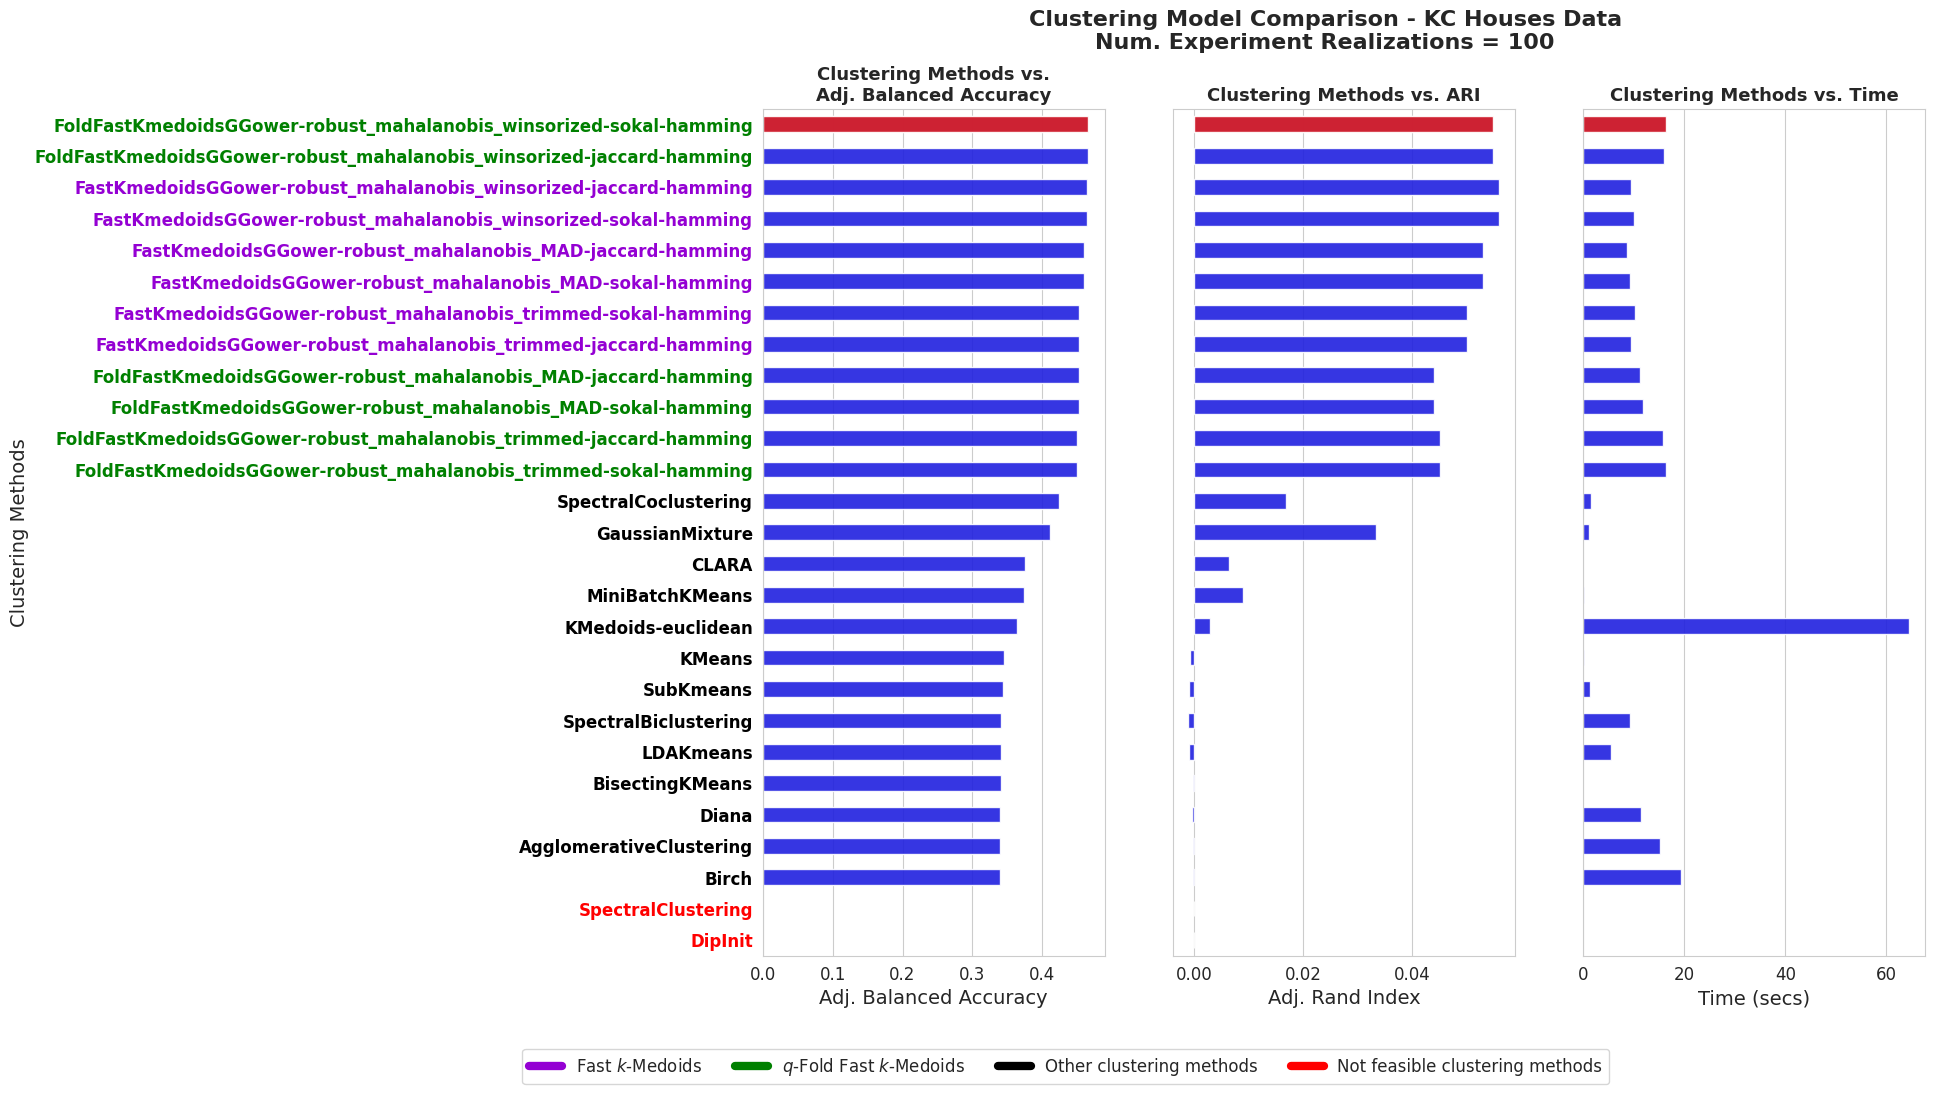

In [14]:
fig, axes = plt.subplots(1,3, figsize=(15,11))
axes = axes.flatten()

ax = sns.barplot(x=avg_adj_accuracy[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[0])
ax = sns.barplot(x=[avg_adj_accuracy[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[0])

ax = sns.barplot(x=avg_ari[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[1])
ax = sns.barplot(x=[avg_ari[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[1])

ax = sns.barplot(x=avg_time[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[2])
ax = sns.barplot(x=[avg_time[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[2])

axes[0].set_ylabel('Clustering Methods', size=14)
axes[0].set_xlabel('Adj. Balanced Accuracy', size=14)
#axes[0].set_xticks(np.round(np.linspace(0, np.max(accuracy_list), 7),2)) 
axes[0].tick_params(axis='y', labelsize=12)    
axes[0].tick_params(axis='x', labelsize=12)  
axes[0].set_title('Clustering Methods vs.\nAdj. Balanced Accuracy', size=13, weight='bold')

axes[1].set_xlabel('Adj. Rand Index', size=14)
#axes[1].set_xticks(np.round(np.linspace(0, np.max(adj_rand_index_list), 7),2)) 
axes[1].tick_params(axis='x', labelsize=12)  
axes[1].set_title('Clustering Methods vs. ARI', size=13, weight='bold')
axes[1].set_yticklabels([])

axes[2].set_xlabel('Time (secs)', size=14)
#axes[2].set_xticks(np.round(np.linspace(0, np.max(time_list), 7),2)) 
axes[2].tick_params(axis='x', labelsize=12)  
axes[2].set_title('Clustering Methods vs. Time', size=13, weight='bold')
axes[2].set_yticklabels([])

for label in axes[0].get_yticklabels():
    if label.get_text() in our_methods_1:
        label.set_weight('bold')
        label.set_color('darkviolet') 
    elif label.get_text() in our_methods_2:
        label.set_weight('bold')
        label.set_color('green') 
    elif label.get_text() in other_methods:
        label.set_weight('bold')
        label.set_color('black') 
    elif label.get_text() in not_feasible_methods:
        label.set_weight('bold')
        label.set_color('red') 

# Create legend elements
legend_elements = [
    plt.Line2D([0], [0], color='darkviolet', lw=6, label='Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='green', lw=6, label='$q$-Fold Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='black', lw=6, label='Other clustering methods'),
    plt.Line2D([0], [0], color='red', lw=6, label='Not feasible clustering methods')
]

# Add legend to the figure
axes[0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(2.5, -0.1), ncol=len(legend_elements), fontsize=12)

fig.suptitle("Clustering Model Comparison - KC Houses Data\nNum. Experiment Realizations = 100", fontsize=16, fontweight='bold', y=0.97)

plot_filename = f'plot_results_exp_4_kc_houses_{file_id}_acc.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [15]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'models'
avg_results_df = avg_results_df.drop(['labels', 'adj_labels'], axis=1)
avg_results_df_sorted_acc = avg_results_df.sort_values(by='adj_accuracy', ascending=False)
avg_results_df_sorted_ari = avg_results_df.sort_values(by='ARI', ascending=False)

In [16]:
avg_results_df_sorted_acc

,time,adj_accuracy,ARI
models,,,
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming,15.911442,0.465626,0.054831
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,16.370522,0.465626,0.054831
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,10.103974,0.463583,0.055946
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming,9.475400,0.463583,0.055946
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming,8.715798,0.459878,0.052929
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,9.327084,0.459878,0.052929
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,10.175367,0.451990,0.050013
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming,9.485514,0.451990,0.050013
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,11.788286,0.451926,0.044026


In [17]:
avg_results_df_sorted_ari

,time,adj_accuracy,ARI
models,,,
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming,9.475400,0.463583,0.055946
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,10.103974,0.463583,0.055946
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,16.370522,0.465626,0.054831
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming,15.911442,0.465626,0.054831
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming,8.715798,0.459878,0.052929
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,9.327084,0.459878,0.052929
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,10.175367,0.451990,0.050013
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming,9.485514,0.451990,0.050013
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,16.360499,0.449905,0.045085


In [18]:
random_state_mds = 35084

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=random_state_mds) 

fastGG = FastGGowerDistMatrix(frac_sample_size=0.07, random_state=random_state_mds, p1=p1, p2=p2, p3=p3, 
                 d1='robust_mahalanobis', d2='jaccard', d3='hamming', 
                 robust_method='winsorized', alpha=0.05)

fastGG.compute(X)

X_mds = mds.fit_transform(fastGG.D_GGower)

/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [19]:
#outliers_bool = np.array([0 if x not in outliers_idx else 1 for x in range(0, len(X))])

sorted_methods_accuracy = list(avg_results_df_sorted_acc.index)

our_methods_1_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_1]
our_methods_2_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_2]
other_methods_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in other_methods]
best_our_methods_1 = our_methods_1_sorted_acc[0]
best_our_methods_2 = our_methods_2_sorted_acc[0]
best_other_methods = other_methods_sorted_acc[0]
additional_methods = ['KMeans', 'GaussianMixture']

methods_to_plot = [best_our_methods_1, best_our_methods_2, best_other_methods] + additional_methods
names_to_plot = [('Best Fast k-medoids' if x in our_methods_1 else 'Best q-Fold Fast k-medoids' if x in our_methods_2 else x) for x in methods_to_plot]
names_to_plot = dict(zip(methods_to_plot, names_to_plot))
y_pred_dict = {names_to_plot[method]: results[random_state_mds]['adj_labels'][method][fastGG.sample_index] for method in methods_to_plot}
accuracy_dict = {names_to_plot[method]: results[random_state_mds]['adj_accuracy'][method] for method in methods_to_plot}
time_dict = {names_to_plot[method]: results[random_state_mds]['time'][method] for method in methods_to_plot}

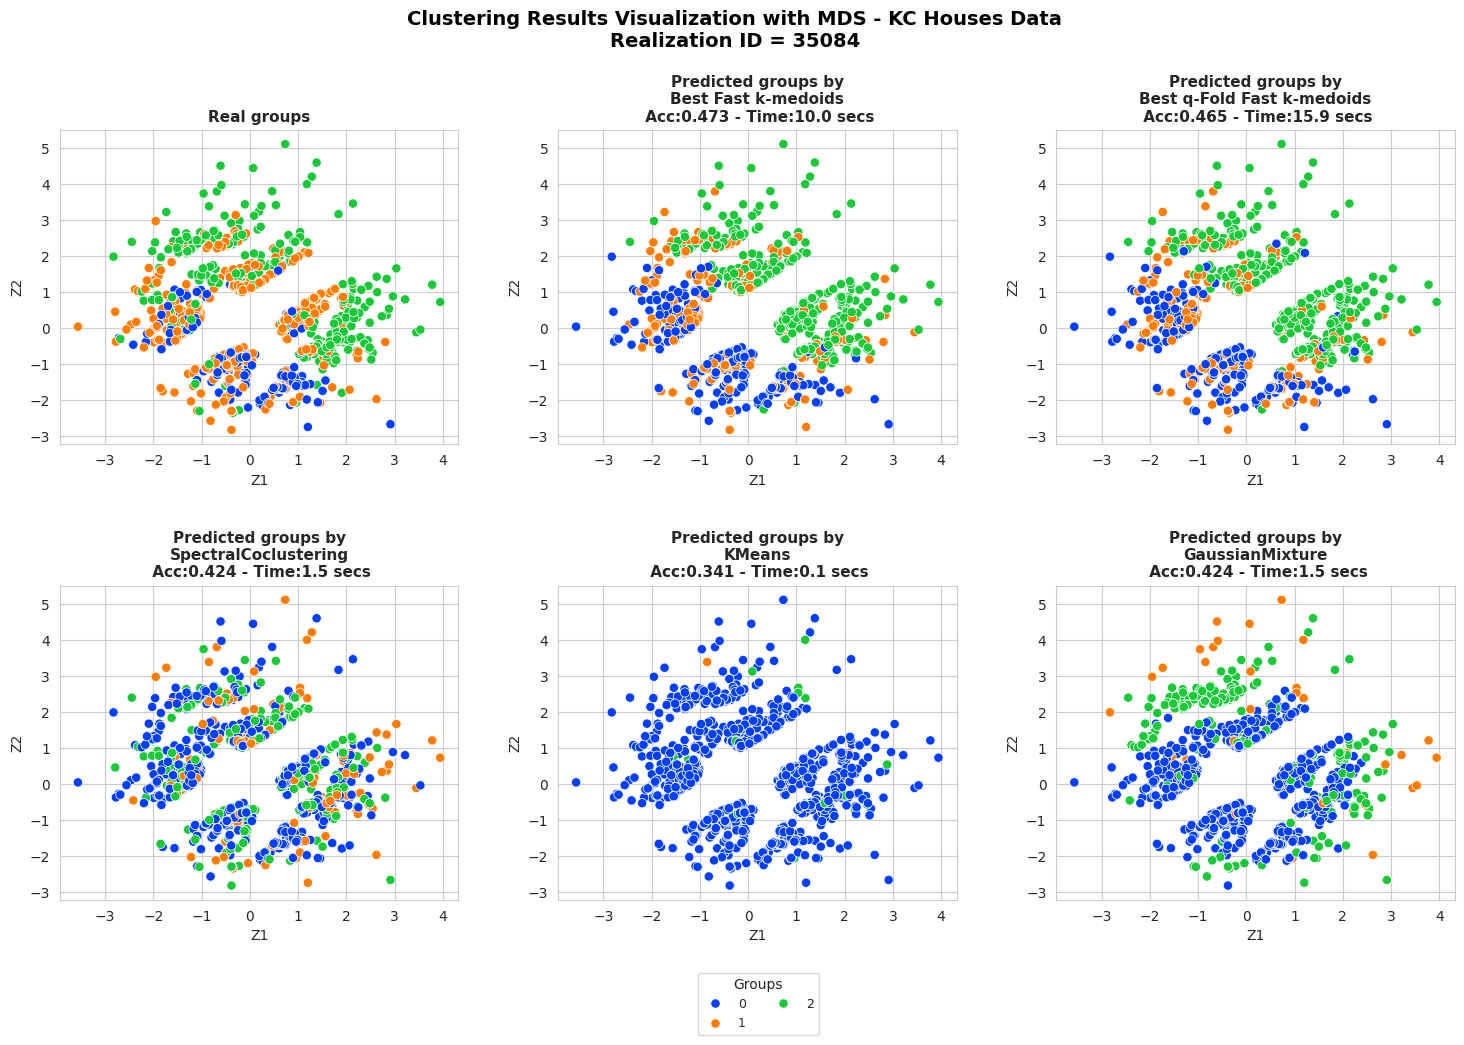

In [24]:
plot_filename = f'mds_plot_exp_4_kc_houses_{file_id}.png'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'kc_houses')
plot_save_path = os.path.join(results_folder_path, plot_filename)

clustering_MDS_plot_multiple_methods(X_mds=X_mds, y_pred=y_pred_dict, 
                                     y_true=y[fastGG.sample_index],
                                     title=f"Clustering Results Visualization with MDS - KC Houses Data\nRealization ID = {random_state_mds}", 
                                     accuracy=accuracy_dict, time=time_dict, n_rows=2,
                                     figsize=(18,10), bbox_to_anchor=(0.67,-1.9), 
                                     title_size=14, title_weight='bold', 
                                     subtitles_size=11,
                                     points_size=45, title_height=1, 
                                     wspace=0.25, hspace=0.45, 
                                     outliers_boolean=None, #outliers_bool[fastGG.sample_index],
                                     n_cols_legend=2, legend_title='Groups', legend_size=9, 
                                     save = True, file_name = plot_save_path
)

**TO DO**
- Probar resultados con balanced acc 
- Probar resultados con 2 clusters en vez de 3
- Meter ncluster como parte del output en el processing de todos los real data